In [1]:
from pettingzoo.classic import connect_four_v3

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [3]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots

(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


In [4]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()

print(
    state["observation"].shape
) 
print(state["observation"][:, :, 0])  
print(state["observation"][:, :, 1])  

print(state["action_mask"])


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [5]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [6]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [7]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                    print(obs['action_mask'])
                return i

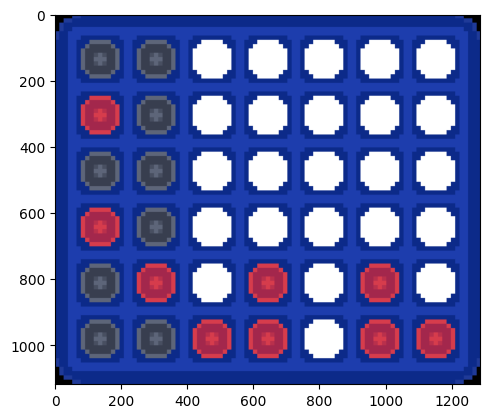

Player 1: Left Player won
[[ 1  1  0  0  0  0  0]
 [-1  1  0  0  0  0  0]
 [ 1  1  0  0  0  0  0]
 [-1  1  0  0  0  0  0]
 [ 1 -1  0 -1  0 -1  0]
 [ 1  1 -1 -1  0 -1 -1]]
[0 0 1 1 1 1 1]


1

In [8]:
agent0 = RandomPlayer()
agent1 = PlayLeftmostLegal()

play_game(env, agent0, agent1, display=True)

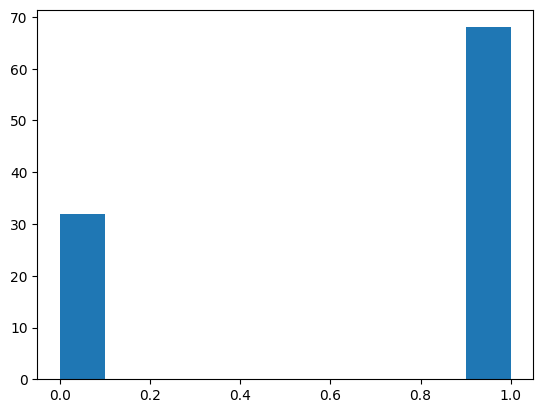

In [9]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [10]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [11]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

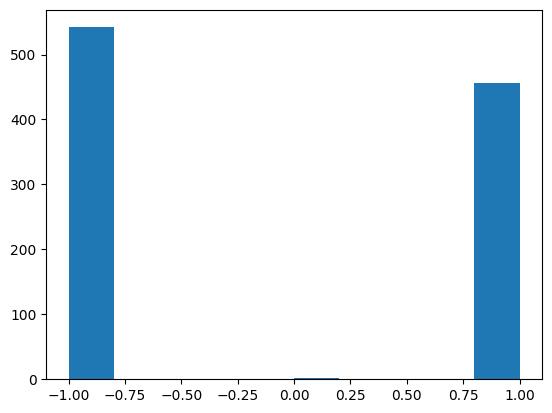

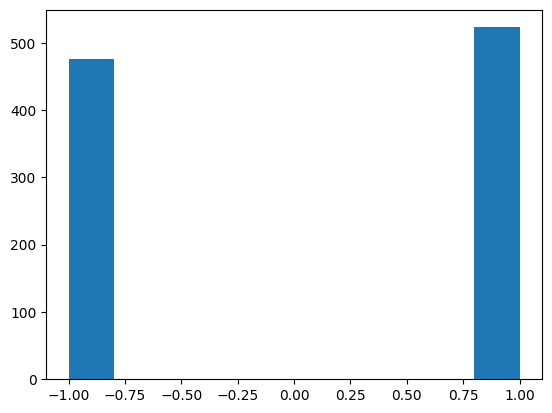

In [12]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Q-learning Agent 



### Defining the agent

In [13]:
import random

class QLearningAgent:
    def __init__(self, alpha=0.5, epsilon=0.1, gamma=0.99, epsilon_min=0.00001, epsilon_step=0.001):
        self.name = "Q-Learning Agent"
        self.q_table = {}
        self.alpha = alpha # learning rate
        self.epsilon = epsilon # exploration rate
        self.gamma = gamma # discount rate
        self.rng = np.random.default_rng() # random number generator

        self.epsilon_min = epsilon_min
        self.epsilon_step = epsilon_step

    def get_action(self, obs_mask, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if random.random() < epsilon:
            return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])
        else:
            return self.best_choice_with_mask(np.arange(7), obs_mask["action_mask"], obs_mask["observation"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())
    
    def best_choice_with_mask(self, arr, mask, obs):
        """
        Selects the action with the highest Q-value
        """
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        q_values = [self.q_table.get((tuple(obs.flatten()), action), 0) for action in masked_arr.compressed()]
        max_q = max(q_values)
        choice = np.random.choice([action for action, q in zip(masked_arr.compressed(), q_values) if q == max_q])
        return choice

    def update(self, state, action, reward, done, next_state):
        obs = state["observation"]
        next_obs = next_state["observation"]

        if (tuple(obs.flatten()), action) not in self.q_table:
            self.q_table[(tuple(obs.flatten()), action)] = 0

        if (tuple(next_obs.flatten()), action) not in self.q_table:
            self.q_table[(tuple(next_obs.flatten()), action)] = 0

        # Q-learning update
        q_next = max([self.q_table.get((tuple(next_obs.flatten()), a), 0) for a in range(7)])
        self.q_table[(tuple(obs.flatten()), action)] += self.alpha * (reward + self.gamma * q_next - self.q_table[(tuple(obs.flatten()), action)])

        self.epsilon_decay()
        
    def epsilon_decay(self):
        self.epsilon = max(self.epsilon - self.epsilon_step, self.epsilon_min)

### Training the agent

In [14]:
def train_one_game(agent, opponent, first_player=True):
    eval_env = EnvAgainstPolicy(env, opponent, first_player=first_player)
    done = False
    eval_env.reset()
    obs, _, _, _, _ = eval_env.last()
    while not done:
        # We get the action from the agent
        action = agent.get_action(obs, epsilon=0)
        if action is None:
            # The agent cannot play: draw?
            return 0
        # print(obs['action_mask'],list(np.where(obs['action_mask'] ==1)[0]), action)
        # We move according to the action
        eval_env.step(action)
        next_obs, reward, done, _, _ = eval_env.last()
        # We update the agent's Q-table
        agent.update(obs, action, reward, done, next_obs)

        if done and reward==1:
            # The agent won
            return 1
        elif done and reward==-1:
            # The agent lost
            return -1
        
        obs = next_obs

    # The game ended in a draw
    return 0

def train(agent, opponent, N_episodes=10, N_games=100, first_player=True, alternate_first_player=False):
    # We print the evolution of the agent's statistics, and at the end we plot the evolution of the win rate
    print(f"{'Episode':<10} {'Win':<10} {'Loss':<10} {'Draw':<10}")
    win_rate = []
    for i in range(N_episodes):
        win = 0
        loss = 0
        draw = 0
        for _ in range(N_games):
            result = train_one_game(agent, opponent, first_player=first_player)
            if result == 1:
                win += 1
            elif result == -1:
                loss += 1
            else:
                draw += 1
        print(f"{i:<10} {win:<10} {loss:<10} {draw:<10}")
        win_rate.append(win / N_games)

        if alternate_first_player:
            first_player = not first_player

    plt.plot(win_rate)
    plt.xlabel("Episode")
    plt.ylabel("Win rate")
    plt.title("Evolution of the win rate for {} against {}".format(agent.name, opponent.name))
    plt.show()
    

In [15]:
import pickle

def save_agent(agent, name):
    # Save the agent's Q-table
    # We try to optimize the size of the file by removing the useless entries
    q_table = {}
    for key, value in agent.q_table.items():
        if value != 0:
            q_table[key] = value
    
    with open(name, 'wb') as f:
        pickle.dump(q_table, f)

def load_agent(name):
    # Load the agent's Q-table
    agent = QLearningAgent()
    with open(name, 'rb') as f:
        agent.q_table = pickle.load(f)
    return agent

In [18]:
def get_pts_up(board, l, c):
    if l <= 2:
        return 0
    lined_up = 1
    while board[l - lined_up, c ] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            return 100
    if board[l - lined_up, c ] == 0:
        return lined_up
    return 0

def get_pts_right(board, l, c):
    if c >= 4:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    while board[l, c + lined_up] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            return 100
    if board[l, c + lined_up] == 0:
        right_possibility = 1
    if c != 0 :
        if board[l, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def get_pts_right_down(board, l, c):
    if l >= 2 or c >= 4:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    while board[l + lined_up, c + lined_up] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            return 100
    if board[l + lined_up, c + lined_up] == 0:
        right_possibility = 1
    if c != 0 and l != 0 :
        if board[l - 1, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def get_pts_right_up(board, l, c):
    if l <= 2 or c >= 4:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    while board[l - lined_up, c + lined_up] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            return 100
    if lined_up >= 4:
        return 100
    if board[l - lined_up, c + lined_up] == 0 :
        right_possibility = 1
    if c != 0 and l != 5 :
        if board[l + 1, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def evaluate_position(board):
    ''' Cette fonction  prend une grille de puissance 4 en entrée
    La fonction retourne un score
    Plus le score est élevé, plus le joueur 1 est en bonne position
    '''
    score_1 = 0
    score_2 = 0
    for l in range(6):
        for c in range(7):
            if board[l,c] == 1:
                score_1 = score_1 + get_pts_up(board, l, c) + get_pts_right(board, l, c) + get_pts_right_down(board, l, c) + get_pts_right_up(board, l, c)
            if board[l,c] == -1:
                score_2 = score_2 + get_pts_up(board, l, c) + get_pts_right(board, l, c) + get_pts_right_down(board, l, c) + get_pts_right_up(board, l, c)
    #print('Score de 1 :', score_1)
    #print('Score de 2 :', score_2)
    return score_1 - score_2


In [19]:
def new_move(board, i):
    layer = 5
    bottom = board[layer,i]
    while bottom !=0 and layer>0 :
        #print(i,"on monte d'un cran")
        layer -= 1
        bottom = board[layer,i]
    if layer == 0 and bottom !=0:
        print("on est tout en haut y a pas de place")
    else :
        new_board = board.copy()
        #print(i,"on va ajouter un pion ici")
        new_board[layer,i] = 1
    return new_board

def get_move_score(board, i):
    board_after_i = new_move(board, i)
    a = evaluate_position(board_after_i)
    return a

In [20]:
class Malynx:
    def __init__(self):
        self.name = "Malynx Player"

    def get_action(self, obs_mask, epsilon=None):
        board = obs_mask['observation'][:, :, 0]- obs_mask['observation'][:, :, 1]
        if np.sum(obs_mask['observation']) < 2 :
            return 3
        best_move_score = - 1000
        best_move = 10
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                move_score = get_move_score(board, i)
                if move_score > best_move_score:
                    best_move_score = move_score
                    best_move = i
        return best_move

Episode    Win        Loss       Draw      
0          8          92         0         
1          53         47         0         
2          100        0          0         
3          100        0          0         
4          100        0          0         
5          100        0          0         
6          100        0          0         
7          100        0          0         
8          100        0          0         
9          100        0          0         


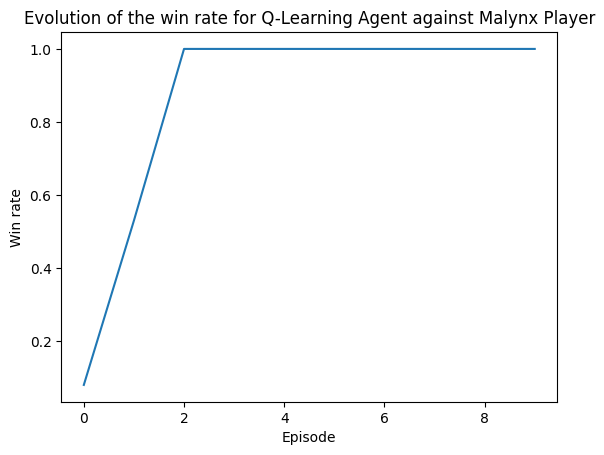

In [29]:
try: 
    agent = load_agent("agent_q_learner.pkl")
except:
    agent = QLearningAgent()

opponent = Malynx()
train(agent, opponent, N_episodes=10, N_games=100, first_player=True)

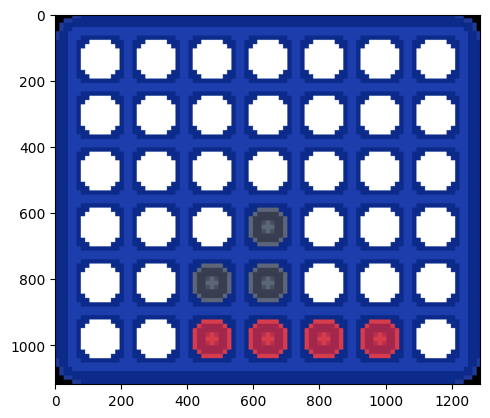

Player 0: Q-Learning Agent won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0 -1 -1  0  0  0]
 [ 0  0  1  1  1  1  0]]
[1 1 1 1 1 1 1]


0

In [33]:
agent0 = Malynx()
agent1 = agent

play_game(env, agent1, agent0, display=True)

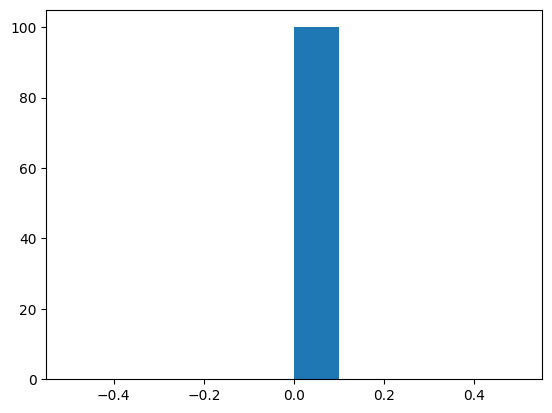

In [28]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

In [17]:
train(agent, opponent, N_episodes=500, N_games=100, first_player=False)

Episode    Win        Loss       Draw      
0          80         20         0         
1          80         20         0         
2          81         19         0         
3          84         16         0         
4          83         17         0         
5          80         20         0         
6          78         22         0         
7          78         22         0         
8          73         27         0         
9          83         17         0         
10         84         16         0         
11         79         20         1         
12         78         22         0         
13         85         15         0         
14         76         24         0         
15         79         20         1         
16         81         19         0         
17         70         30         0         
18         81         18         1         
19         75         25         0         
20         81         19         0         
21         81         19        

KeyboardInterrupt: 

Episode    Win        Loss       Draw      
0          91         9          0         
1          88         12         0         
2          92         8          0         
3          87         13         0         
4          89         11         0         
5          87         13         0         
6          86         14         0         
7          85         15         0         
8          89         11         0         
9          91         9          0         
10         92         7          1         
11         88         12         0         
12         89         11         0         
13         94         6          0         
14         86         14         0         
15         87         13         0         
16         91         9          0         
17         95         5          0         
18         89         11         0         
19         89         11         0         
20         92         8          0         
21         85         15        

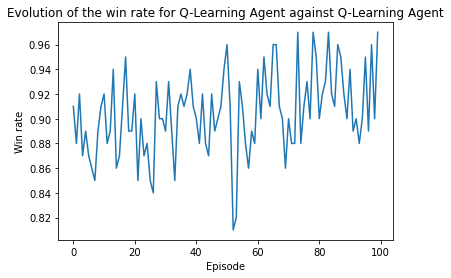

In [ ]:
train(agent, agent, N_episodes=100, N_games=100, first_player=False)

Episode    Win        Loss       Draw      
0          83         17         0         
1          80         20         0         
2          85         15         0         
3          83         17         0         
4          84         16         0         
5          90         10         0         
6          89         11         0         
7          85         15         0         
8          84         16         0         
9          80         20         0         
10         78         22         0         
11         87         13         0         
12         86         14         0         
13         88         12         0         
14         86         14         0         
15         84         16         0         
16         88         12         0         
17         86         14         0         
18         79         21         0         
19         83         17         0         
20         82         18         0         
21         89         11        

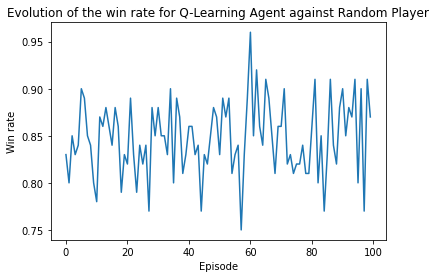

In [ ]:
train(agent, opponent, N_episodes=100, N_games=100, first_player=True)

#### Saving the agent

In [25]:
save_agent(agent, "agent_q_learner.pkl")

## Testing the agent

In [33]:
play_game(env, agent, RandomPlayer(), display=True)

KeyboardInterrupt: 

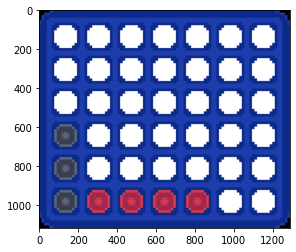

Player 0: Q-Learning Agent won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [-1  1  1  1  1  0  0]]
[1 1 1 1 1 1 1]


0

In [31]:
play_game(env, agent, PlayLeftmostLegal(), display=True)

# Let's play!

In [ ]:
class HumanPlayer:
    def __init__(self):
        self.name = input("Enter your name: ")

    def get_action(self, obs_mask, epsilon=None):
        if np.where(obs_mask["action_mask"] == 1)[0] == []:
            print("You cannot play")
            return None
        print(obs_mask["observation"])
        print("Action mask: ", obs_mask["action_mask"])
        action = int(input("Enter your action: "))
        while action not in np.where(obs_mask["action_mask"] == 1)[0]:
            print("Invalid action")
            action = int(input("Enter your action: "))
        return action
    
play_game(env, HumanPlayer(), agent, display=True)